In [370]:
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
import yfinance as yfin
from scipy import stats

yfin.pdr_override()

# Historical Method for Calculating VaR #

[*********************100%%**********************]  1 of 1 completed


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   2.,   0.,   1.,   0.,   0.,   0.,   3.,   1.,   0.,   3.,
          1.,   0.,   2.,   0.,   1.,   2.,   4.,   1.,   5.,   6.,   9.,
          4.,   2.,   3.,   4.,   3.,   5.,   8.,   7.,   8.,  10.,  16.,
         22.,  19.,  11.,  18.,  20.,  19.,  24.,  24.,  29.,  37.,  46.,
         47.,  63.,  64.,  62.,  89.,  89., 129., 173., 200., 203., 172.,
        152., 126., 119.,  88.,  68.,  65.,  64.,  49.,  37.,  46.,  31.,
         28.,  34.,  30.,  23.,  28.,  10.,   9.,  12.,  13.,  10.,   9.,
         12.,   9.,   6.,   5.,   1., 

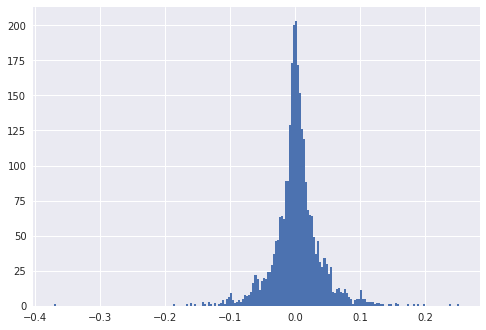

In [371]:
start = datetime.date(2016, 1, 1)
end = datetime.date.today()

prices = pd.DataFrame(web.DataReader(["BTC-USD"], start, end)["Adj Close"])
returns = prices.pct_change()
returns = returns.rename(columns={"Adj Close": "Bitcoin"})
returns = returns.dropna()
plt.hist(returns, bins = 200)

In [372]:
myarray = np.linspace(0, 100, 101)
myarray

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100.])

In [373]:
np.percentile(myarray, 0)

0.0

## Value at Risk (VaR) ##

In [374]:
def getHistoricalVar(returns, confidenceLevel):
    VaR = 100 * np.percentile(returns, 100 - confidenceLevel)  # converted to percent
    
    print(f"With {confidenceLevel:.2f}% confidence, we can say the most our portfolio will lose in a day is {VaR:.2f}% using historical VaR.")
    
    return VaR

In [375]:
getHistoricalVar(returns["Bitcoin"], 95)

With 95.00% confidence, we can say the most our portfolio will lose in a day is -5.79% using historical VaR.


-5.7924077656909825

In [376]:
getHistoricalVar(returns["Bitcoin"], 99)

With 99.00% confidence, we can say the most our portfolio will lose in a day is -10.36% using historical VaR.


-10.358544412292408

## Conditional Value at Risk (CVaR) ##

In [377]:
def getHistoricalCVar(returns, confidenceLevel):
    VaR = np.percentile(returns, 100 - confidenceLevel)
    CVaR_array = returns[returns <= VaR]
    CVaR = CVaR_array.mean() * 100  # convert to percent
    
    print(f"With {confidenceLevel:.2f}% confidence, our Daily Conditional Value at Risk is {CVaR:.2f}% using historical VaR.")
    
    return CVaR

In [378]:
VaR_BTC = getHistoricalVar(returns["Bitcoin"], 95)
VaR_BTC

With 95.00% confidence, we can say the most our portfolio will lose in a day is -5.79% using historical VaR.


-5.7924077656909825

In [379]:
CVaR_BTC = getHistoricalCVar(returns["Bitcoin"], 95)
CVaR_BTC

With 95.00% confidence, our Daily Conditional Value at Risk is -8.73% using historical VaR.


-8.726048056535143

In [380]:
start = datetime.date(2016, 1, 1)
end = datetime.date.today()

prices = pd.DataFrame(web.DataReader(["BLV"], start, end)["Adj Close"])
prices = prices.rename(columns={"Adj Close": "BLV"})
returns = prices.pct_change()
returns = returns.dropna()

[*********************100%%**********************]  1 of 1 completed


In [381]:
VaR_BLV = getHistoricalVar(returns["BLV"], 95)
VaR_BLV

With 95.00% confidence, we can say the most our portfolio will lose in a day is -1.17% using historical VaR.


-1.1711926368836612

In [382]:
CVaR_BLV = getHistoricalCVar(returns["BLV"], 95)
CVaR_BLV

With 95.00% confidence, our Daily Conditional Value at Risk is -1.75% using historical VaR.


-1.7483138631686788

In [383]:
var_df = pd.DataFrame((VaR_BTC, VaR_BLV))
var_df = var_df.rename(columns={0:"VaR"})
var_df["CVaR"] = (CVaR_BTC, CVaR_BLV)
var_df = var_df.rename({0:"BTC", 1:"BLV"}, axis=0)
var_df = var_df / 100  # convert from percent to number.
var_df

,VaR,CVaR
BTC,-0.057924,-0.087260
BLV,-0.011712,-0.017483


Text(0, 0.5, 'CVaR')

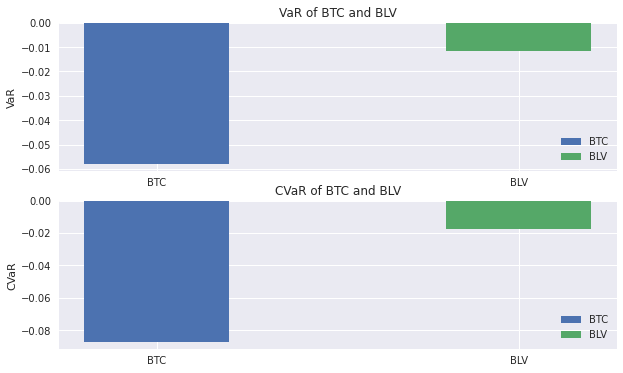

In [384]:
plt.style.use("seaborn")
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].bar(0, var_df["VaR"][0], label="BTC", width=0.4)
axs[0].bar(1, var_df["VaR"][1], label="BLV", width=0.4)
axs[0].set_xticks((0, 1), ("BTC", "BLV"))
axs[0].legend()
axs[0].set_title("VaR of BTC and BLV")
axs[0].set_ylabel("VaR")

axs[1].bar(0, var_df["CVaR"][0], label="BTC", width=0.4)
axs[1].bar(1, var_df["CVaR"][1], label="BLV", width=0.4)
axs[1].set_xticks((0, 1), ("BTC", "BLV"))
axs[1].legend()
axs[1].set_title("CVaR of BTC and BLV")
axs[1].set_ylabel("CVaR")

# Parametric Method for Calculating VaR #

In [385]:
start = datetime.date(2010, 1, 1)
end = datetime.date.today()

prices = pd.DataFrame(web.DataReader(["AAPL"], start, end)["Adj Close"])
prices = prices.rename(columns={"Adj Close": "AAPL"})
returns = prices.pct_change()
returns = returns.dropna()

[*********************100%%**********************]  1 of 1 completed


In [386]:
# Calculate VaR with parametric method assuming a Normal distribution.
mean = returns.AAPL.mean()
std = returns.AAPL.std()
confidence = 0.05
VaR_AAPL = (100 * stats.norm.ppf(confidence, mean, std)).round(3)
print(f"Daily VaR of AAPL is {VaR_AAPL}% with {1 - confidence} confidence, assuming Normal distribution.")

Daily VaR of AAPL is -2.83% with 0.95 confidence, assuming Normal distribution.


In [387]:
# Calculate VaR with parametric method assuming a T-distribution.

dof = 4  # degrees of freedom
tVaR = np.sqrt((dof - 2) / dof) * stats.t.ppf(confidence, dof) * std - mean
(100 * tVaR).round(3)
print(f"Daily VaR of AAPL is {(tVaR * 100):.2f}% with {1 - confidence} confidence, assuming T-distribution.")

Daily VaR of AAPL is -2.81% with 0.95 confidence, assuming T-distribution.
